## **Modeling Car Insurances**
Insurance companies invest a lot of time and money into optimizing their pricing and accurately estimating the likelihood that customers will make a claim. In many countries insurance it is a legal requirement to have car insurance in order to drive a vehicle on public roads, so the market is very large!

(`Source: https://www.accenture.com/_acnmedia/pdf-84/accenture-machine-leaning-insurance.pdf`) 

Knowing all of this, a fictional car insurance have requested my services in building a model to predict whether a customer will make a claim on their insurance during the policy period. As they have very little expertise and infrastructure for deploying and monitoring machine learning models, they've asked me to identify the single feature that results in the best performing model, as measured by accuracy, so they can start with a simple model in production.

They have supplied you with their customer data as a csv file called `car_insurance.csv`, along with a table detailing the column names and descriptions below.

## The dataset

| Column | Description |
|--------|-------------|
| `id` | Unique client identifier |
| `age` | Client's age: <br> <ul><li>`0`: 16-25</li><li>`1`: 26-39</li><li>`2`: 40-64</li><li>`3`: 65+</li></ul> |
| `gender` | Client's gender: <br> <ul><li>`0`: Female</li><li>`1`: Male</li></ul> |
| `driving_experience` | Years the client has been driving: <br> <ul><li>`0`: 0-9</li><li>`1`: 10-19</li><li>`2`: 20-29</li><li>`3`: 30+</li></ul> |
| `education` | Client's level of education: <br> <ul><li>`0`: No education</li><li>`1`: High school</li><li>`2`: University</li></ul> |
| `income` | Client's income level: <br> <ul><li>`0`: Poverty</li><li>`1`: Working class</li><li>`2`: Middle class</li><li>`3`: Upper class</li></ul> |
| `credit_score` | Client's credit score (between zero and one) |
| `vehicle_ownership` | Client's vehicle ownership status: <br><ul><li>`0`: Does not own their vehilce (paying off finance)</li><li>`1`: Owns their vehicle</li></ul> |
| `vehcile_year` | Year of vehicle registration: <br><ul><li>`0`: Before 2015</li><li>`1`: 2015 or later</li></ul> |
| `married` | Client's marital status: <br><ul><li>`0`: Not married</li><li>`1`: Married</li></ul> |
| `children` | Client's number of children |
| `postal_code` | Client's postal code | 
| `annual_mileage` | Number of miles driven by the client each year |
| `vehicle_type` | Type of car: <br> <ul><li>`0`: Sedan</li><li>`1`: Sports car</li></ul> |
| `speeding_violations` | Total number of speeding violations received by the client | 
| `duis` | Number of times the client has been caught driving under the influence of alcohol |
| `past_accidents` | Total number of previous accidents the client has been involved in |
| `outcome` | Whether the client made a claim on their car insurance (response variable): <br><ul><li>`0`: No claim</li><li>`1`: Made a claim</li></ul> |

### Tasks
- Identify the single feature of the data that is the best predictor of whether a customer will put in a claim (the "outcome" column), excluding the "id" column.

- Store as a DataFrame called best_feature_df, containing columns named "best_feature" and "best_accuracy" with the name of the feature with the highest accuracy, and the respective accuracy score.

In [25]:
# Importing necessary libraries
import pandas as pd
from statsmodels.formula.api import logit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample

In [13]:
# Reading csv file

car_df = pd.read_csv('car_insurance.csv')

print(car_df.head(3))

       id  age  gender driving_experience    education         income  \
0  569520    3       0               0-9y  high school    upper class   
1  750365    0       1               0-9y         none        poverty   
2  199901    0       0               0-9y  high school  working class   

   credit_score  vehicle_ownership vehicle_year  married  children  \
0      0.629027                1.0   after 2015      0.0       1.0   
1      0.357757                0.0  before 2015      0.0       0.0   
2      0.493146                1.0  before 2015      0.0       0.0   

   postal_code  annual_mileage vehicle_type  speeding_violations  duis  \
0        10238         12000.0        sedan                    0     0   
1        10238         16000.0        sedan                    0     0   
2        10238         11000.0        sedan                    0     0   

   past_accidents  outcome  
0               0      0.0  
1               0      1.0  
2               0      0.0  


In [14]:
# Cleaning and transforming the dataset

#print(car_df.isna().sum())
# Imputing median value to NaN values at "credit_score" & "annual_milage"
car_df['credit_score'] = car_df['credit_score'].fillna(car_df['credit_score'].median())
car_df['annual_mileage'] = car_df['annual_mileage'].fillna(car_df['annual_mileage'].median())
# Ensure none NaN value exists in the columns that were found
assert car_df['credit_score'].isna().sum() == 0
assert car_df['annual_mileage'].isna().sum() == 0

# Difining the maps to map each categorical column with

vehicle_type_map = {
    'sedan' : '0', 
    'sports car' : '1' 
}

vehicle_year_map = {
    'before 2015' : '0',
    'after 2015' : '1'
}

driving_exp_map = {
    '0-9y' : '0',
    '10-19y' : '1',
    '20-29y' : '2',
    '30y+' : '3' 
}

education_map = {
    'none': '0',
    'high school' : '1',
    'university' : '2'
}

income_map = {
    'poverty' : '0',
    'working class' : '1',
    'middle class' : '2',
    'upper class' : '3' 
}

# Transform the categorical columns
car_df['driving_experience'] = car_df['driving_experience'].map(driving_exp_map)
car_df['income'] = car_df['income'].map(income_map)
car_df['education'] = car_df['education'].map(education_map)
car_df['vehicle_type'] = car_df['vehicle_type'].map(vehicle_type_map)
car_df['vehicle_year'] = car_df['vehicle_year'].map(vehicle_year_map)

#Before starting the models, "id", "postal_code" should be dropped
modeldata_cars = car_df[['age', 'gender', 'driving_experience', 'education', 
                         'income', 'credit_score', 
                         'vehicle_type', 'vehicle_ownership', 
                         'vehicle_year', 'married', 'children', 
                         'annual_mileage', 'speeding_violations', 'duis',
                         'past_accidents', 'outcome']]

print(modeldata_cars.head(10))


   age  gender driving_experience education income  credit_score vehicle_type  \
0    3       0                  0         1      3      0.629027            0   
1    0       1                  0         0      0      0.357757            0   
2    0       0                  0         1      1      0.493146            0   
3    0       1                  0         2      1      0.206013            0   
4    1       1                  1         0      1      0.388366            0   
5    2       0                  2         1      3      0.619127            0   
6    3       1                  3         1      3      0.492944            0   
7    1       0                  0         2      1      0.468689            0   
8    2       0                  2         2      1      0.521815            0   
9    2       0                  0         1      3      0.561531            0   

   vehicle_ownership vehicle_year  married  children  annual_mileage  \
0                1.0            1   

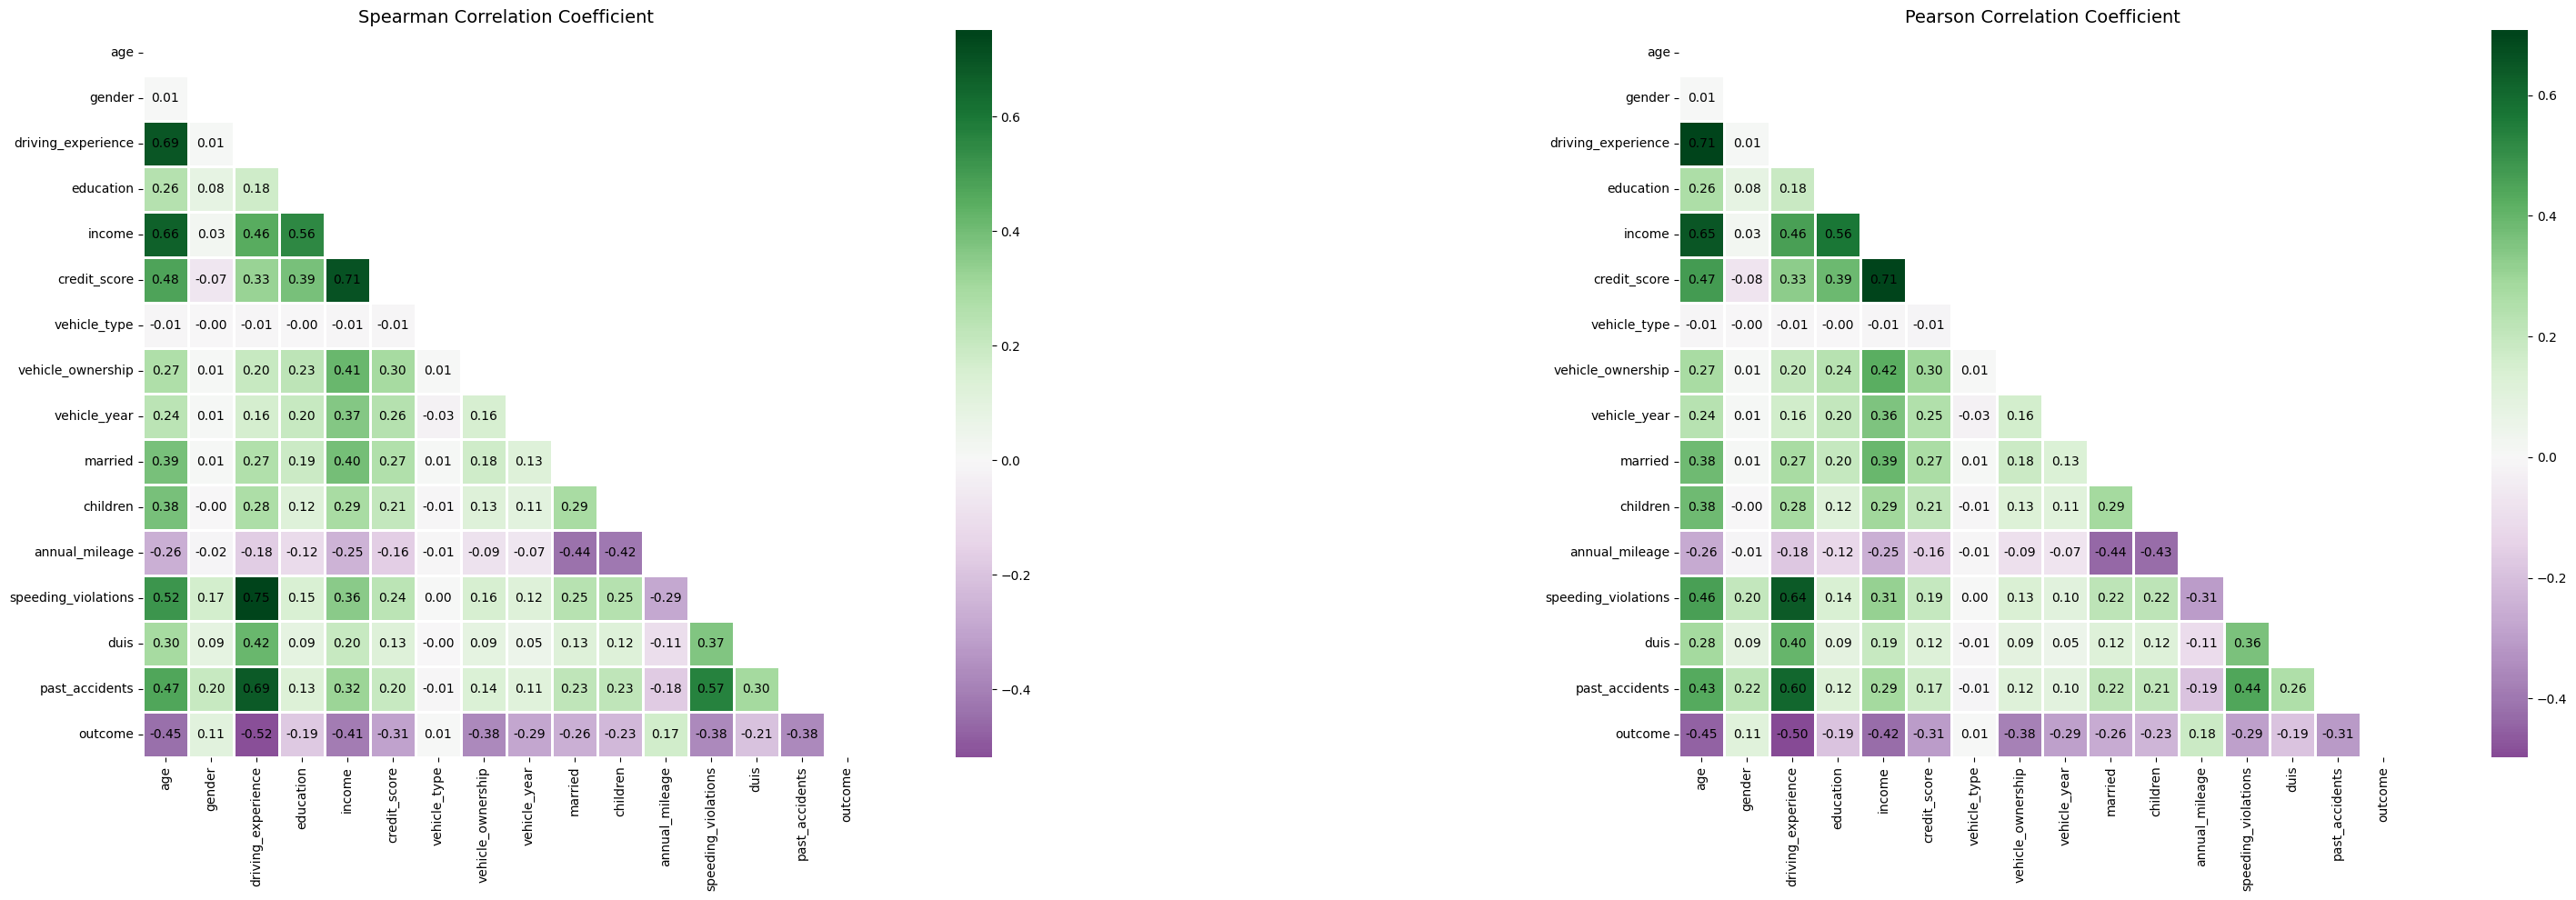

In [15]:
# Performing EDA
# Calculating Correlation Coefficients

# Pearson's Corr-Coeff
corr_pearson = modeldata_cars.corr(method='pearson')

# Spearman's Corr-Coeff
corr_spearman = modeldata_cars.corr(method='spearman')

# CHARTS
# Creating a triangle mask for the upper triangle of the table
mask = np.triu(np.ones_like(corr_spearman, dtype=bool))

# Creating subplots
fig, axes = plt.subplots(1, 2, figsize=(36, 10)) # 1 row, 2 columns

# Heatmap: Spearman
sns.heatmap(corr_spearman, annot=True, annot_kws={"size": 10, "color": "black"}, mask=mask, cmap='PRGn', center=0,
            square=True, linewidths=.8, ax=axes[0], fmt=".2f")
axes[0].set_title("Spearman Correlation Coefficient", fontsize=14)

# Heatmap: Pearson
sns.heatmap(corr_pearson, annot=True, annot_kws={"size": 10, "color": "black"}, mask=mask, cmap='PRGn', center=0,
            square=True, linewidths=.8, ax=axes[1], fmt=".2f")
axes[1].set_title("Pearson Correlation Coefficient", fontsize=14)

# Show the 2 charts
plt.tight_layout()
plt.show()


Absolute Frequencies for each class of: outcome
No Claim    6867
Claim       3133
Name: count, dtype: int64.
Percentage Values for each class of: outcome
No Claim    68.67
Claim       31.33
Name: count, dtype: float64.


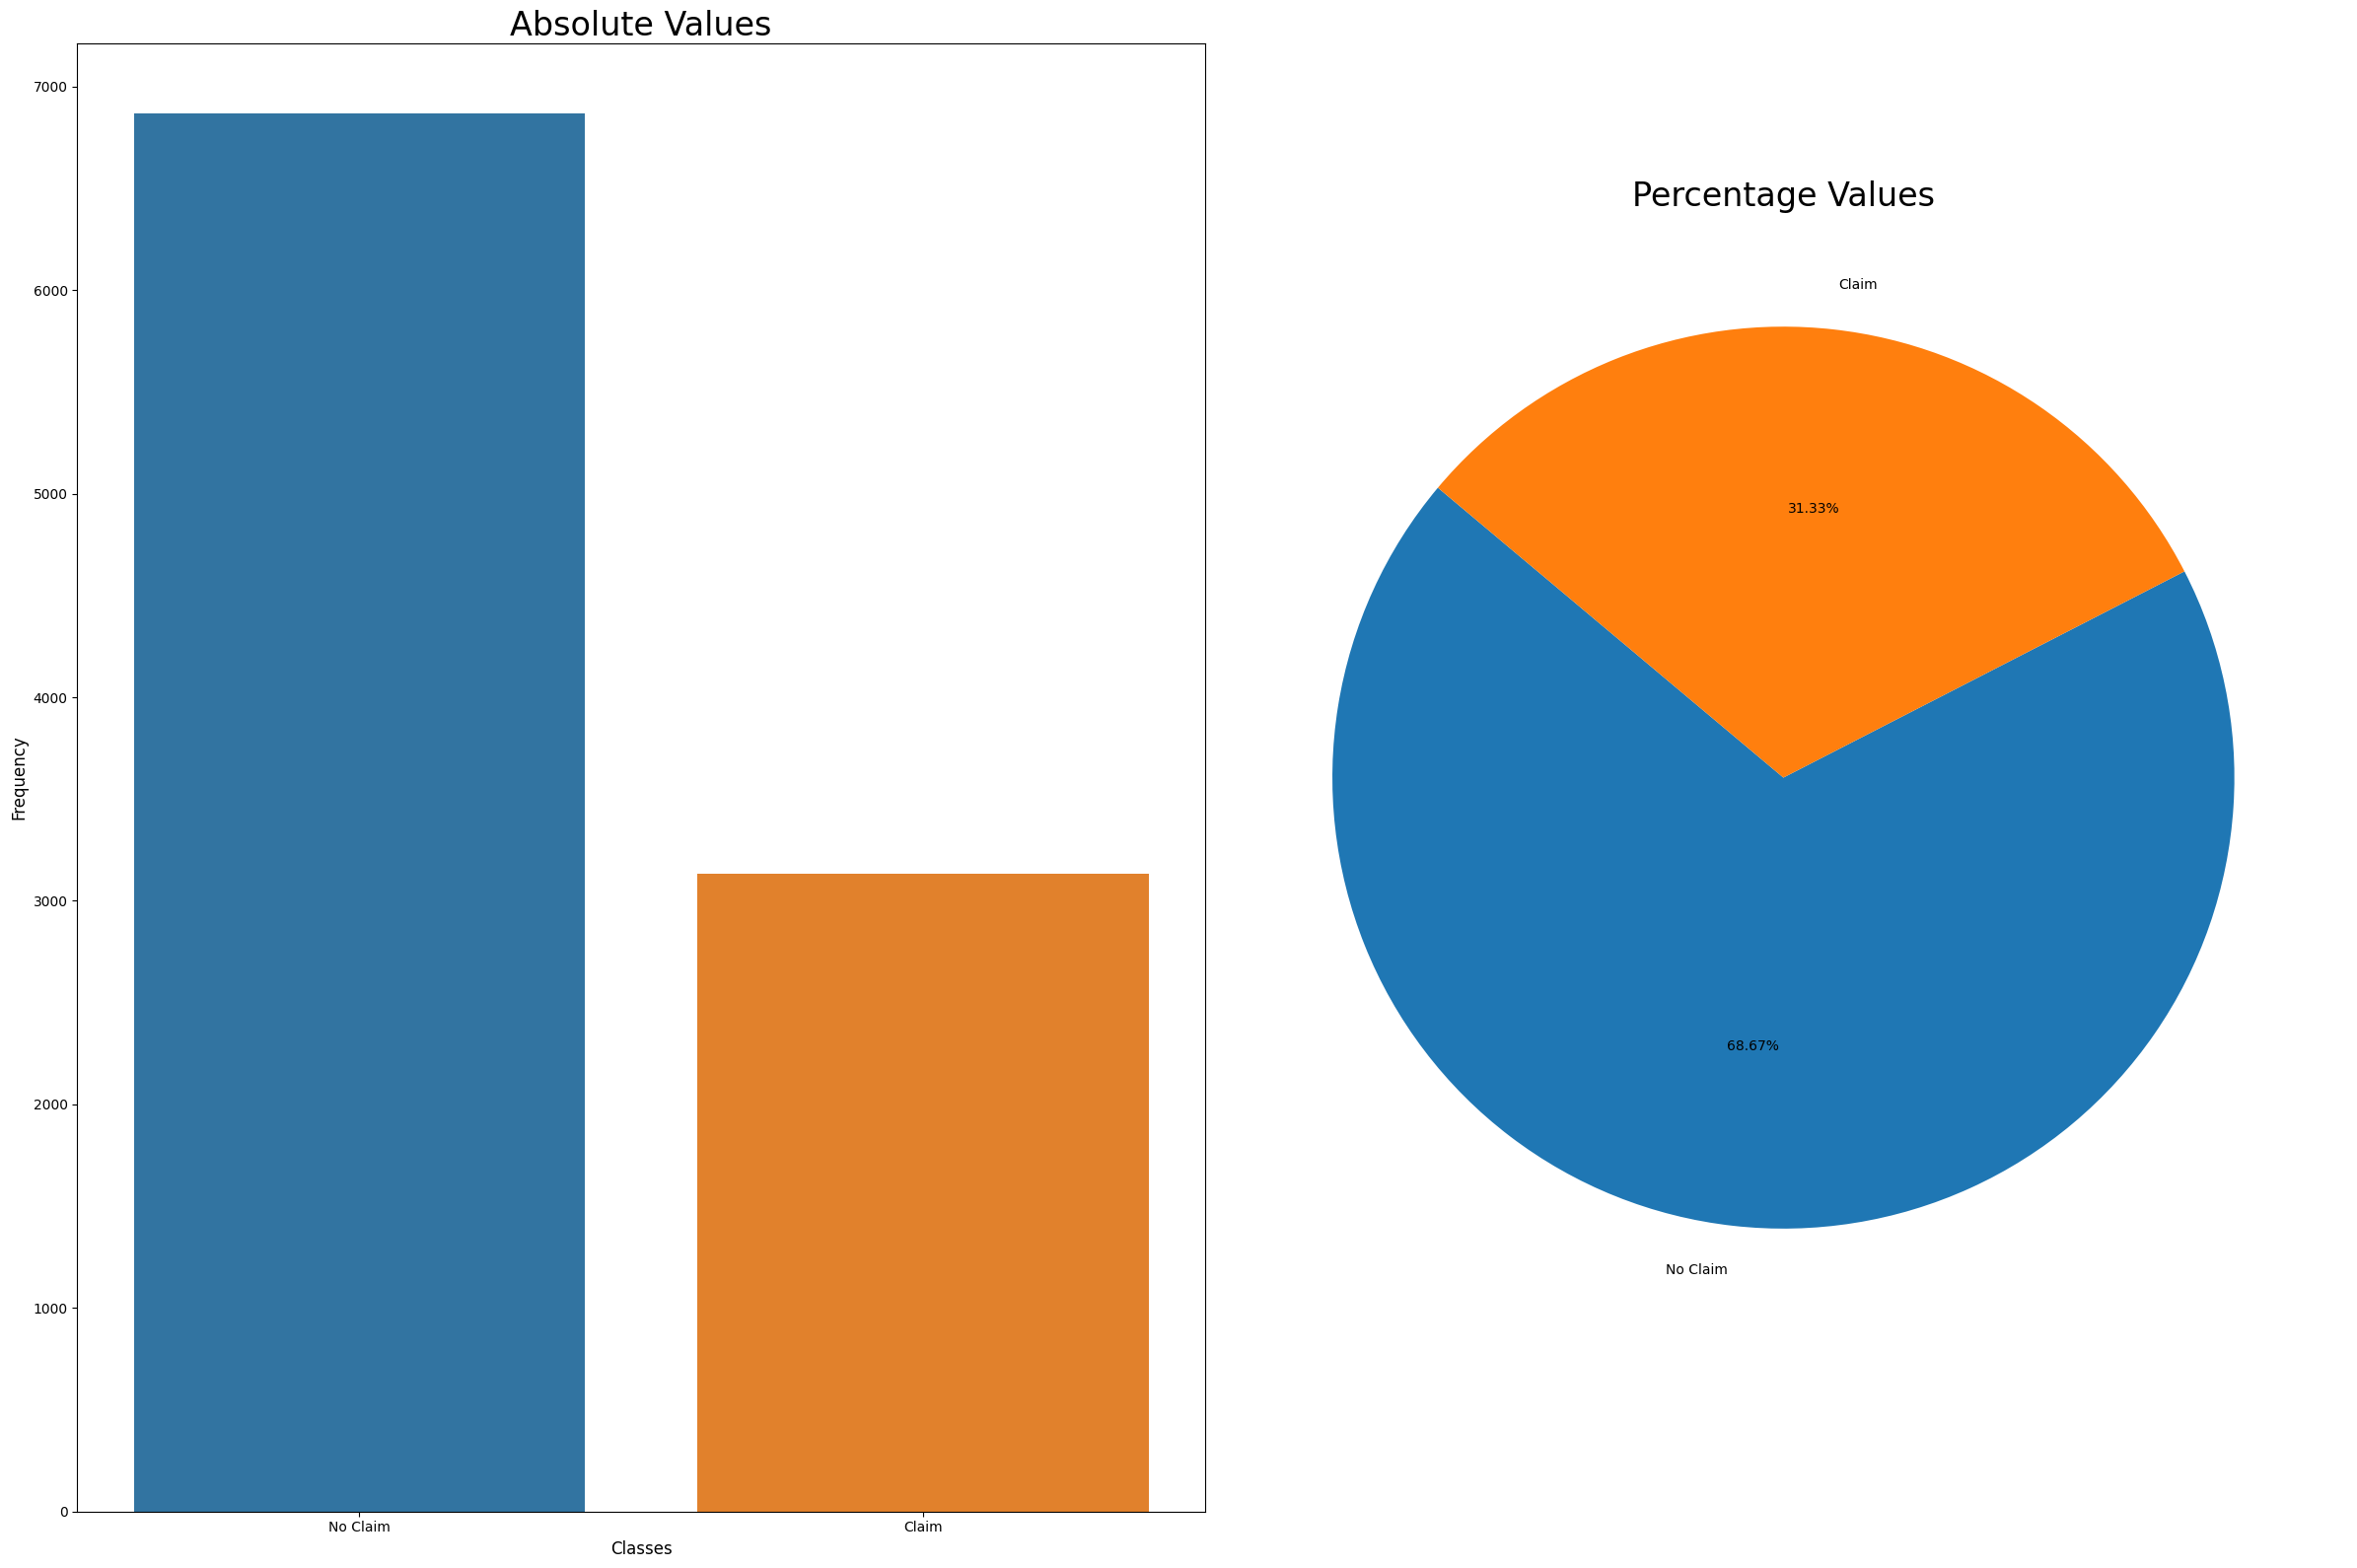

In [16]:
# Calculate target var's frequencies
class_counts = modeldata_cars['outcome'].value_counts()
class_counts.index = class_counts.index.map({0 : 'No Claim', 1 : 'Claim'})

# Show absolute and percentage values
print(f"Absolute Frequencies for each class of: {class_counts}.")
print(f"Percentage Values for each class of: {round((class_counts/len(modeldata_cars)*100), 2)}.")

# Creating subplots
fig, axes = plt.subplots(1, 2, figsize=(24, 16))

# Bar Chart for the Absolute Values
sns.barplot(ax=axes[0], x=class_counts.index,
            hue = class_counts.index,
            y=class_counts.values, palette="tab10", 
            legend=False)
axes[0].set_title("Absolute Values", fontsize=24)
axes[0].set_xlabel("Classes", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)

# Pie Chart for the Percentage Values
axes[1].pie(class_counts.values, labels=class_counts.index, 
            autopct='%1.2f%%', startangle=140, 
            colors=sns.color_palette("tab10"))
axes[1].set_title("Percentage Values", fontsize=24)

# Tight Layout for better visualization
plt.tight_layout()
plt.show()

## Functions

### `run_logit`

This function performs logistic regression for each explanatory variable separately and returns the confusion matrices for each model.

- **Arguments**:
  - `expl_vars` (list): A list containing the names of the explanatory variables.
  - `response_var` (str): The name of the response variable.
  - `data` (pd.DataFrame): A DataFrame containing the dataset.

- **Returns**:
  - `x` (dict): A dictionary where each key is an explanatory variable and each value is the confusion matrix resulting from the logistic regression performed on that variable.

- **Usage**:
  ```python
  confusion_matrices = run_logit(expl_vars, response_var, data)
  ```

### `acc_find`

This function calculates the accuracy of the prediction tables (confusion matrices) generated from each explanatory variable and returns the results.

- **Arguments**:
  - `x` (dict): A dictionary containing all the explanatory variables as keys and the prediction tables (confusion matrices) of logistic regressions as values.

- **Returns**:
  - `acc_results` (dict): A dictionary containing the explanatory variables as keys and the calculated accuracies for each model as values.

- **Usage**:
  ```python
  accuracy_results = acc_find(confusion_matrices)
  ```

## Example Workflow

1. **Run Logistic Regression**:
   - Use `run_logit` to perform logistic regression on each explanatory variable and obtain confusion matrices.

2. **Calculate Accuracy**:
   - Use `acc_find` to calculate the accuracy of each model based on the confusion matrices.

These functions are designed to streamline the process of evaluating the predictive power of individual features in a dataset using logistic regression.


In [17]:
# Defining 2 very helpful functions

def run_logit(expl_vars, response_var, data):
    """
    Performs logistic regression for each of 
    the explanatory variables seperately and returns 
    the confusion matrices for every model.

    Args:
        expl_vars (list): A list with the names of the explanatory variables
        response_var (str): The name of the response variable
        data (pd.DataFrame): DataFrame containing the data

    Returns:
        x (dict): The dictionary with the confusion matrices for every logistic regression performed
    """
    x = {}
    for i in expl_vars:
        # Creating the formula for every explanatory variable
        formula = f"{response_var} ~ {i}"
        
        # Creating and fitting the model
        model = logit(formula=formula, data=data)
        fit = model.fit(disp=0)    
        result = fit.pred_table()
        # Storing the results in the dictionary 
        x[i] = result
    return x


def acc_find(x):
    """
    Calculates the accuracy of the pred_tables given from each explanatory variable and returns it 

    Args:
        x (dict): A dictionary containing all the explanatory variables as keys and the pred_tables of logistic regressions as values.
    
    Returns:
        acc_results (dict): The dictionary containing the explanatory variables as keys and the calculated accuracies for each model fitted before as values.
    """
    acc_results = {}
    for key, value in x.items():
        accuracy = (value[0,0]+value[1,1])/(value[0,0]+value[0,1]+value[1,0]+value[1,1])
        acc_results[key] = accuracy
    
    return acc_results
        


In [18]:
# Get the features and the target data

response_var = 'outcome'

expl_vars = ['age', 'gender', 'driving_experience', 'education', 
                         'income', 'credit_score', 
                         'vehicle_type', 'vehicle_ownership', 
                         'vehicle_year', 'married', 'children', 
                         'annual_mileage', 'speeding_violations', 'duis',
                         'past_accidents']

# Apply the run_logit function
logit_tables_dict = run_logit(expl_vars=expl_vars, response_var=response_var, data=modeldata_cars)

# Apply the acc_find function
accuracy_results = acc_find(logit_tables_dict)




In [19]:
# Get the max key-value pair from the results
# This is the best predictor of the features
max_acc = max(accuracy_results.values())
best_predictor = max(accuracy_results, key=accuracy_results.get)

In [20]:
# Store as a DataFrame
best_feature_df = pd.DataFrame({'best_feature' : [best_predictor],
                                'best_accuracy' : [max_acc]})

print(best_feature_df)

         best_feature  best_accuracy
0  driving_experience         0.7771


In [21]:
# Define features and target
features = modeldata_cars.drop(columns=['outcome'])  
target = modeldata_cars['outcome']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

# Random Forest for Feature Importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance scores
rf_feature_importances = rf_model.feature_importances_
rf_importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': rf_feature_importances})
rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)
print("Random Forest Feature Importances:")
print(rf_importance_df)

# Logistic Regression for Coefficient Analysis
# Standardize features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train_scaled, y_train)

# Get coefficients
log_reg_coefficients = log_reg_model.coef_[0]
log_reg_coeff_df = pd.DataFrame({'Feature': features.columns, 'Coefficient': log_reg_coefficients})
log_reg_coeff_df['Abs_Coefficient'] = np.abs(log_reg_coeff_df['Coefficient'])
log_reg_coeff_df = log_reg_coeff_df.sort_values(by='Abs_Coefficient', ascending=False)

print("\nLogistic Regression Coefficients:")
print(log_reg_coeff_df[['Feature', 'Coefficient']])

Random Forest Feature Importances:
                Feature  Importance
5          credit_score    0.203273
2    driving_experience    0.126842
11       annual_mileage    0.110431
7     vehicle_ownership    0.084104
0                   age    0.081506
12  speeding_violations    0.068705
4                income    0.068074
8          vehicle_year    0.056068
14       past_accidents    0.055258
3             education    0.037049
1                gender    0.033302
9               married    0.025022
10             children    0.023332
13                 duis    0.016072
6          vehicle_type    0.010964

Logistic Regression Coefficients:
                Feature  Coefficient
2    driving_experience    -1.645674
7     vehicle_ownership    -0.767184
8          vehicle_year    -0.765913
1                gender     0.467676
14       past_accidents    -0.396878
12  speeding_violations     0.231358
9               married    -0.209119
11       annual_mileage     0.149964
10             childr

In [26]:
# Addressing Imbalance with Resampling
# Combine X_train and y_train for resampling
train_data = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
majority_class = train_data[train_data['outcome'] == 0]
minority_class = train_data[train_data['outcome'] == 1]

# Upsample minority class
minority_upsampled = resample(minority_class, 
                              replace=True,     # sample with replacement
                              n_samples=len(majority_class),    # to match majority class
                              random_state=42)  # reproducible results

# Combine majority class with upsampled minority class
upsampled_train_data = pd.concat([majority_class, minority_upsampled])

# Separate features and target
X_train_upsampled = upsampled_train_data.drop('outcome', axis=1)
y_train_upsampled = upsampled_train_data['outcome']

# Standardize features
scaler = StandardScaler()
X_train_upsampled_scaled = scaler.fit_transform(X_train_upsampled)
X_test_scaled = scaler.transform(X_test)


# Hyperparameter tuning for Logistic Regression
log_reg_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg_grid = GridSearchCV(log_reg, log_reg_params, cv=5, scoring='f1')
log_reg_grid.fit(X_train_upsampled_scaled, y_train_upsampled)

print("Best Logistic Regression Parameters:", log_reg_grid.best_params_)

# Evaluate the best logistic regression model
y_pred_log_reg = log_reg_grid.predict(X_test_scaled)
print("\nLogistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_log_reg))
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

# Random Forest with hyperparameter tuning
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='f1')
rf_grid.fit(X_train_upsampled, y_train_upsampled)

print("Best Random Forest Parameters:", rf_grid.best_params_)

# Evaluate the best random forest model
y_pred_rf = rf_grid.predict(X_test)
print("\nRandom Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Best Logistic Regression Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}

Logistic Regression Confusion Matrix:
[[1094  273]
 [ 102  531]]

Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.80      0.85      1367
         1.0       0.66      0.84      0.74       633

    accuracy                           0.81      2000
   macro avg       0.79      0.82      0.80      2000
weighted avg       0.83      0.81      0.82      2000

Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}

Random Forest Confusion Matrix:
[[1220  147]
 [ 216  417]]

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87      1367
         1.0       0.74      0.66      0.70       633

    accuracy                           0.82      2000
   macro avg       0.79      0.78      0.78      2000
weighted avg  

In [37]:
# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()


Final Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.80      0.85      1367
         1.0       0.66      0.84      0.74       633

    accuracy                           0.81      2000
   macro avg       0.79      0.82      0.80      2000
weighted avg       0.83      0.81      0.82      2000



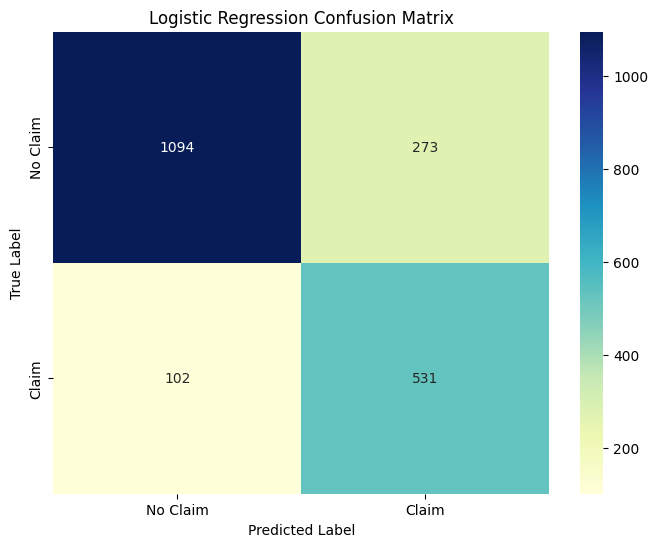

In [38]:
# Train the final Logistic Regression model with the best parameters
final_log_reg = LogisticRegression(C=0.01, penalty='l1', solver='saga', max_iter=1000, class_weight='balanced', random_state=42)
final_log_reg.fit(X_train_upsampled_scaled, y_train_upsampled)

# Evaluate the final model
y_pred_final = final_log_reg.predict(X_test_scaled)

print("\nFinal Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_final))

# Plot the confusion matrix for the Logistic Regression model
plot_confusion_matrix(y_test, y_pred_final, class_names=['No Claim', 'Claim'], title='Logistic Regression Confusion Matrix')

Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}

Final Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87      1367
         1.0       0.74      0.66      0.70       633

    accuracy                           0.82      2000
   macro avg       0.79      0.78      0.78      2000
weighted avg       0.81      0.82      0.82      2000



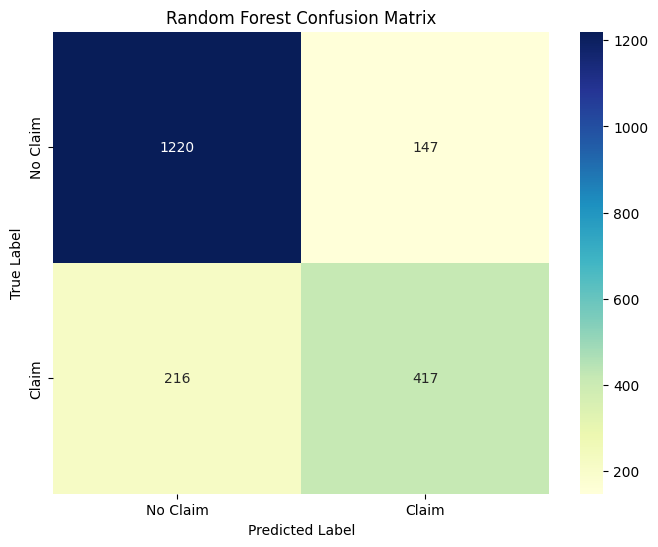

In [39]:
# Assuming rf_grid is the GridSearchCV object for Random Forest
best_rf_params = rf_grid.best_params_
print("Best Random Forest Parameters:", best_rf_params)

# Train the final Random Forest model with the best parameters
final_rf = RandomForestClassifier(
    n_estimators=best_rf_params['n_estimators'],
    max_depth=best_rf_params['max_depth'],
    min_samples_split=best_rf_params['min_samples_split'],
    class_weight='balanced',
    random_state=42
)
final_rf.fit(X_train_upsampled, y_train_upsampled)

# Evaluate the final model
y_pred_rf_final = final_rf.predict(X_test)

print("\nFinal Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf_final))

# Plot the confusion matrix for the Random Forest model
plot_confusion_matrix(y_test, y_pred_rf_final, class_names=['No Claim', 'Claim'], title='Random Forest Confusion Matrix')